# How to do KMeans Clustering in Python for Soccer Analysis

Based on the [video](https://www.youtube.com/watch?v=rXHChgdXc0M) by McKay Johns

### Importing

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from random import randint

from statsbombpy import sb

from mplsoccer.pitch import Pitch

from sklearn.cluster import KMeans

### Getting Data from Statsbomb API

In [2]:
# Getting data for WC 2018 3rd place match between England and Belgium
# events = sb.events(match_id = 8657, split=True, flatten_attrs=False)["passes"] # don't have end location
events = sb.events(match_id = 8657)
events.head()

credentials were not supplied. open data access only


,50_50,bad_behaviour_card,ball_receipt_outcome,ball_recovery_offensive,ball_recovery_recovery_failure,block_deflection,block_save_block,carry_end_location,counterpress,dribble_outcome,...,shot_statsbomb_xg,shot_technique,shot_type,substitution_outcome,substitution_replacement,tactics,team,timestamp,type,under_pressure
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,"{'formation': 343, 'lineup': [{'player': {'id'...",Belgium,00:00:00.000,Starting XI,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,"{'formation': 352, 'lineup': [{'player': {'id'...",England,00:00:00.000,Starting XI,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,England,00:00:00.000,Half Start,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,Belgium,00:00:00.000,Half Start,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,England,00:00:00.000,Half Start,NaN


In [3]:
events.columns

Index(['50_50', 'bad_behaviour_card', 'ball_receipt_outcome',
       'ball_recovery_offensive', 'ball_recovery_recovery_failure',
       'block_deflection', 'block_save_block', 'carry_end_location',
       'counterpress', 'dribble_outcome', 'dribble_overrun', 'duel_outcome',
       'duel_type', 'duration', 'foul_committed_advantage',
       'foul_committed_card', 'foul_committed_offensive',
       'foul_committed_type', 'foul_won_advantage', 'foul_won_defensive',
       'goalkeeper_body_part', 'goalkeeper_end_location', 'goalkeeper_outcome',
       'goalkeeper_position', 'goalkeeper_technique', 'goalkeeper_type', 'id',
       'index', 'interception_outcome', 'location', 'match_id', 'minute',
       'pass_aerial_won', 'pass_angle', 'pass_assisted_shot_id',
       'pass_backheel', 'pass_body_part', 'pass_cross', 'pass_cut_back',
       'pass_deflected', 'pass_end_location', 'pass_goal_assist',
       'pass_height', 'pass_length', 'pass_outcome', 'pass_recipient',
       'pass_shot_assist

In [4]:
# events['type'].unique()
passes_mask = (events['type'] == 'Pass') & (events['team'] == 'Belgium')
passes = events.loc[passes_mask, ['team', 'type', 'location', 'pass_end_location', 'pass_angle', 'pass_length']].reset_index()
passes

,index,team,type,location,pass_end_location,pass_angle,pass_length
0,6,Belgium,Pass,"[61.0, 41.0]","[51.0, 41.0]",3.141593,10.000000
1,7,Belgium,Pass,"[51.0, 40.0]","[37.0, 18.0]",-2.137526,26.076809
2,8,Belgium,Pass,"[33.0, 18.0]","[28.0, 35.0]",1.856848,17.720045
3,9,Belgium,Pass,"[21.0, 44.0]","[22.0, 73.0]",1.536327,29.017237
4,10,Belgium,Pass,"[50.0, 76.0]","[56.0, 78.0]",0.321751,6.324555
...,...,...,...,...,...,...,...
494,1184,Belgium,Pass,"[88.0, 4.0]","[85.0, 13.0]",1.892547,9.486833
495,1185,Belgium,Pass,"[85.0, 13.0]","[88.0, 3.0]",-1.279340,10.440307
496,1186,Belgium,Pass,"[88.0, 3.0]","[91.0, 3.0]",0.000000,3.000000
497,1187,Belgium,Pass,"[91.0, 3.0]","[87.0, 7.0]",2.356194,5.656854


In [5]:
# Split location column to x, y columns
passes[['x','y']] = passes['location'].to_list()

# Split pass_end_location column to end_x, end_y columns
passes[['endX','endY']] = passes['pass_end_location'].to_list()

# Drop location and pass_end_location columns
passes.drop(['location','pass_end_location'], axis=1, inplace=True)

passes

,index,team,type,pass_angle,pass_length,x,y,endX,endY
0,6,Belgium,Pass,3.141593,10.000000,61.0,41.0,51.0,41.0
1,7,Belgium,Pass,-2.137526,26.076809,51.0,40.0,37.0,18.0
2,8,Belgium,Pass,1.856848,17.720045,33.0,18.0,28.0,35.0
3,9,Belgium,Pass,1.536327,29.017237,21.0,44.0,22.0,73.0
4,10,Belgium,Pass,0.321751,6.324555,50.0,76.0,56.0,78.0
...,...,...,...,...,...,...,...,...,...
494,1184,Belgium,Pass,1.892547,9.486833,88.0,4.0,85.0,13.0
495,1185,Belgium,Pass,-1.279340,10.440307,85.0,13.0,88.0,3.0
496,1186,Belgium,Pass,0.000000,3.000000,88.0,3.0,91.0,3.0
497,1187,Belgium,Pass,2.356194,5.656854,91.0,3.0,87.0,7.0


### Implement KMeans Clustering

In [24]:
X = np.array(passes[['x', 'y', 'endX', 'endY']])

In [25]:
kmeans = KMeans(n_clusters = 100, random_state = 100)
kmeans.fit(X)

passes['cluster'] = kmeans.predict(X)

In [26]:
passes.head()

,index,team,type,pass_angle,pass_length,x,y,endX,endY,cluster
0,6,Belgium,Pass,3.141593,10.000000,61.0,41.0,51.0,41.0,45
1,7,Belgium,Pass,-2.137526,26.076809,51.0,40.0,37.0,18.0,0
2,8,Belgium,Pass,1.856848,17.720045,33.0,18.0,28.0,35.0,44
3,9,Belgium,Pass,1.536327,29.017237,21.0,44.0,22.0,73.0,47
4,10,Belgium,Pass,0.321751,6.324555,50.0,76.0,56.0,78.0,37


In [27]:
cluster_keys = passes.cluster.value_counts().keys()
cluster_keys

Int64Index([10, 51,  1, 29, 82, 30,  9,  0, 77, 31,  4, 93, 61, 54,  5,  8, 90,
            58, 72, 16, 49, 12, 57, 44, 25, 28,  2, 37, 39, 95, 20, 71, 67, 94,
             7, 59, 80, 18, 55, 26, 36, 74, 62, 88, 46, 40, 45, 42, 35, 47, 86,
            56, 76, 15, 14, 23,  6, 41, 78, 21, 98,  3, 32, 89, 19, 11, 13, 84,
            64, 99, 24, 22, 81, 69, 33, 66, 48, 83, 79, 65, 68, 43, 60, 53, 85,
            70, 17, 50, 52, 97, 38, 92, 27, 63, 87, 75, 73, 34, 91, 96],
           dtype='int64')

### Plotting

Text(0.5, 1.0, 'Belgium vs England pass clusters. WC 2018')

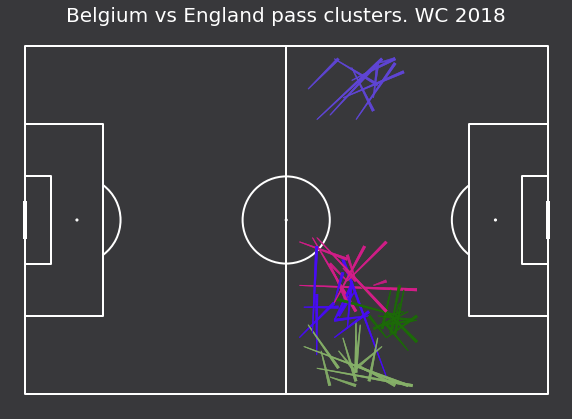

In [28]:
# Random colors for clusters
colors = []

for i in range(100):
    colors.append('#%06X' % randint(0, 0xFFFFFF))
    
# Plotting
fig, ax = plt.subplots(figsize=(10, 10))
fig.set_facecolor('#38383b')
ax.patch.set_facecolor('#38383b')

pitch = Pitch(pitch_type='statsbomb', pitch_color='#38383b', line_color='white', 
              figsize=(10,10), constrained_layout=False, tight_layout=True)

pitch.draw(ax=ax)

for x in range(len(passes['cluster'])):
    color = colors[passes['cluster'][x]]
    if passes['cluster'][x] == cluster_keys[0]:
        pitch.lines(
            xstart=passes['x'][x], ystart=passes['y'][x], 
            xend=passes['endX'][x], yend=passes['endY'][x],
            color=color, lw=3, zorder=2, comet=True, ax=ax
        )
    
    if passes['cluster'][x] == cluster_keys[1]:
        pitch.lines(
            xstart=passes['x'][x], ystart=passes['y'][x], 
            xend=passes['endX'][x], yend=passes['endY'][x],
            color=color, lw=3, zorder=2, comet=True, ax=ax
        )
    
    if passes['cluster'][x] == cluster_keys[2]:
        pitch.lines(
            xstart=passes['x'][x], ystart=passes['y'][x], 
            xend=passes['endX'][x], yend=passes['endY'][x],
            color=color, lw=3, zorder=2, comet=True, ax=ax
        )
    
    if passes['cluster'][x] == cluster_keys[3]:
        pitch.lines(
            xstart=passes['x'][x], ystart=passes['y'][x], 
            xend=passes['endX'][x], yend=passes['endY'][x],
            color=color, lw=3, zorder=2, comet=True, ax=ax
        )
    
    if passes['cluster'][x] == cluster_keys[4]:
        pitch.lines(
            xstart=passes['x'][x], ystart=passes['y'][x], 
            xend=passes['endX'][x], yend=passes['endY'][x],
            color=color, lw=3, zorder=2, comet=True, ax=ax
        )
        
plt.title("Belgium vs England pass clusters. WC 2018", color='white', size=20)

In [29]:
fig.savefig('belgium-pass-clusters-vs-england-wc-2018-bronze-medal.png')